In [1]:
import numpy as np
from PIL import ImageEnhance
from PIL import Image, ImageChops, ImageOps

def load_and_resize_image(image_path, output_shape,
                          zmuv_mean, zmuv_std,
                          transfo_params=None):
    im = Image.open(image_path, mode='r')
    sort_dim = list(np.sort(im.size))
    dim_dst = [0, 0]
    dim_dst[0] = sort_dim[1] / 700.0
    dim_dst[1] = sort_dim[0] / 700.0
    im_new = im
    
    # Dict to keep track of random values.
    chosen_values = {}

    if transfo_params.get('extra_width_crop', False):
        w, h = im_new.size

        if w / float(h) >= 1.3:
            cols_thres = np.where(
                np.max(
                    np.max(
                        np.asarray(im_new),
                        axis=2),
                    axis=0) > 35)[0]

            # Extra cond compared to orig crop.
            if len(cols_thres) > output_shape[0] // 2:
                min_x, max_x = cols_thres[0], cols_thres[-1]
            else:
                min_x, max_x = 0, -1

            im_new = im_new.crop((min_x, 0,
                                  max_x, h))

    if transfo_params.get('crop_height', False):
        w, h = im_new.size

        if w > 1 and 0.98 <= h / float(w) <= 1.02:
            # "Normal" without height crop, do height crop.
            im_new = im_new.crop((0, int(0.05 * h),
                                  w, int(0.95 * h)))

    if transfo_params.get('crop', False) and not \
            transfo_params.get('crop_after_rotation', False):
        do_crop = transfo_params['crop_prob'] > np.random.rand()
        chosen_values['do_crop'] = do_crop

        if do_crop:
            out_w, out_h = im_new.size
            w_dev = int(transfo_params['crop_w'] * out_w)
            h_dev = int(transfo_params['crop_h'] * out_h)
            w0 = np.random.randint(0, w_dev + 1)
            w1 = np.random.randint(0, w_dev + 1)
            h0 = np.random.randint(0, h_dev + 1)
            h1 = np.random.randint(0, h_dev + 1)

            # Add params to dict.
            chosen_values['w0'] = w0
            chosen_values['w1'] = w1
            chosen_values['h0'] = h0
            chosen_values['h1'] = h1

            im_new = im_new.crop((0 + w0, 0 + h0,
                                  out_w - w1, out_h - h1))

    if transfo_params.get('rotation_before_resize', False):
        rotation_param = np.random.randint(
                transfo_params['rotation_range'][0],
                transfo_params['rotation_range'][1])
        chosen_values['rotation_param'] = rotation_param

        im_new = im_new.rotate(rotation_param, resample=Image.BILINEAR,
                               expand=transfo_params.get('rotation_expand',
                                                         False))
        if transfo_params.get('rotation_expand',
                              False):
            im_new = im_new.crop(im_new.getbbox())

    if transfo_params.get('crop_after_rotation', False):
        do_crop = transfo_params['crop_prob'] > np.random.rand()
        chosen_values['do_crop'] = do_crop

        if do_crop:
            out_w, out_h = im_new.size
            w_dev = int(transfo_params['crop_w'] * out_w)
            h_dev = int(transfo_params['crop_h'] * out_h)

            w0 = np.random.randint(0, w_dev + 1)
            w1 = np.random.randint(0, w_dev + 1)
            h0 = np.random.randint(0, h_dev + 1)
            h1 = np.random.randint(0, h_dev + 1)

            # Add params to dict.
            chosen_values['w0'] = w0
            chosen_values['w1'] = w1
            chosen_values['h0'] = h0
            chosen_values['h1'] = h1

            im_new = im_new.crop((0 + w0, 0 + h0,
                                  out_w - w1, out_h - h1))

    # im_new = im_new.thumbnail(output_shape, resample=Image.BILINEAR)
    if transfo_params.get('keep_aspect_ratio', False):
        im_new = make_thumb(im_new, size=output_shape,
                           pad=transfo_params['resize_pad'])
    else:
        im_new = im_new.resize(output_shape, resample=Image.BILINEAR)
    # im_new = im_new.resize(output_shape, resample=Image.BICUBIC)
    # im_new = im_new.resize(map(lambda x: int(x * 1.2), output_shape),
    # resample=Image.BICUBIC)
    # im_new = im_new.crop(im_new.getbbox())

    if transfo_params.get('rotation', False) \
            and not transfo_params.get('rotation_before_resize', False):
        rotation_param = np.random.randint(
                transfo_params['rotation_range'][0],
                transfo_params['rotation_range'][1])
        chosen_values['rotation_param'] = rotation_param

        im_new = im_new.rotate(rotation_param, resample=Image.BILINEAR,
                               expand=transfo_params.get('rotation_expand',
                                                         False))
        if transfo_params.get('rotation_expand',
                              False):
            im_new = im_new.crop(im_new.getbbox())

    # im_new = im_new.resize(output_shape, resample=Image.BICUBIC)
    if transfo_params.get('contrast', False):
        contrast_min, contrast_max = transfo_params['contrast_range']
        contrast_param = np.random.uniform(contrast_min, contrast_max)
        chosen_values['contrast_param'] = contrast_param

        im_new = ImageEnhance.Contrast(im_new).enhance(contrast_param)

    if transfo_params.get('brightness', False):
        brightness_min, brightness_max = transfo_params['brightness_range']
        brightness_param = np.random.uniform(brightness_min,
                                                 brightness_max)
        chosen_values['brightness_param'] = brightness_param

        im_new = ImageEnhance.Brightness(im_new).enhance(brightness_param)

    if transfo_params.get('color', False):
        color_min, color_max = transfo_params['color_range']
        color_param = np.random.uniform(color_min, color_max)
        chosen_values['color_param'] = color_param

        im_new = ImageEnhance.Color(im_new).enhance(color_param)

    if transfo_params.get('flip', False):
        do_flip = transfo_params['flip_prob'] > np.random.rand()
        chosen_values['do_flip'] = do_flip

        if do_flip:
            im_new = im_new.transpose(Image.FLIP_LEFT_RIGHT)

    if output_shape[0] < 200 and False:
        # Otherwise too slow.
        # TODO: Disabled for now
        if 'rotation' in transfo_params and transfo_params['rotation']:
            rotation_param = np.random.randint(
                    transfo_params['rotation_range'][0],
                    transfo_params['rotation_range'][1])

            im_new = im_new.rotate(rotation_param, resample=Image.BILINEAR,
                                   expand=False)
            # im_new = im_new.crop(im_new.getbbox())
            chosen_values['rotation_param2'] = rotation_param

    if transfo_params.get('zoom', False):
        do_zoom = transfo_params['zoom_prob'] > np.random.rand()
        chosen_values['do_zoom'] = do_zoom

        if do_zoom:
            zoom_min, zoom_max = transfo_params['zoom_range']
            out_w, out_h = im_new.size
            w_dev = int(np.random.uniform(zoom_min, zoom_max) / 2 * out_w)
            chosen_values['w_dev'] = w_dev

            im_new = im_new.crop((0 + w_dev,
                                  0 + w_dev,
                                  out_w - w_dev,
                                  out_h - w_dev))
    
    
    if im_new.size != output_shape:
        im_new = im_new.resize(output_shape, resample=Image.BILINEAR)
    im_new = np.asarray(im_new).astype('float32')/255  
    im.close()
    
    im_new = (im_new - zmuv_mean)/(0.05 + zmuv_std)    
    return im_new, dim_dst, chosen_values

In [2]:
transfo_params = {'rotation': True, 'rotation_range': (0, 360),
                          'contrast': True, 'contrast_range': (0.7, 1.3),
                          'brightness': True, 'brightness_range': (0.7, 1.3),
                          'color': True, 'color_range': (0.7, 1.3),
                          'flip': True, 'flip_prob': 0.5,
                          'crop': True, 'crop_prob': 0.4,
                          'crop_w': 0.03, 'crop_h': 0.04,
                          'keep_aspect_ratio': False,
                          'resize_pad': False,
                          'zoom': True, 'zoom_prob': 0.5,
                          'zoom_range': (0.00, 0.05),
                          'paired_transfos': False,
                          'rotation_expand': False,
                          'crop_height': False,
                          'extra_width_crop': True,
                          'rotation_before_resize': False,
                          'crop_after_rotation': True}

none_params = {'rotation': False, 'rotation_range': (0, 360),
                  'contrast': False, 'contrast_range': (0.7, 1.3),
                  'brightness': False, 'brightness_range': (0.7, 1.3),
                  'color': False, 'color_range': (0.7, 1.3),
                  'flip': False, 'flip_prob': 0.5,
                  'crop': False, 'crop_prob': 0.4,
                  'crop_w': 0.03, 'crop_h': 0.04,
                  'keep_aspect_ratio': False,
                  'resize_pad': False,
                  'zoom': False, 'zoom_prob': 0.5,
                  'zoom_range': (0.00, 0.05),
                  'paired_transfos': False,
                  'rotation_expand': False,
                  'crop_height': False,
                  'extra_width_crop': True,
                  'rotation_before_resize': False,
                  'crop_after_rotation': False}

img, dim, chosen = load_and_resize_image("/mnt/lab_data2/avanti/diabetic_retinopathy_messidor/Base11/ds_2_crop_20051019_38557_0100_PP.jpeg",
                      output_shape=(512,512),
                      zmuv_mean=0.042,
                      zmuv_std=0.204,
                      transfo_params=transfo_params)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


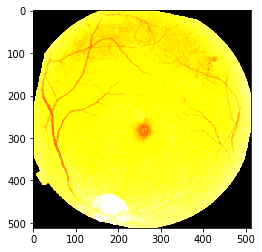

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(img)

In [4]:
print(dim, chosen)

[0.9828571428571429, 0.9814285714285714] {'do_crop': True, 'w0': 18, 'w1': 3, 'h0': 24, 'h1': 4, 'rotation_param': 282, 'contrast_param': 1.2551679058527432, 'brightness_param': 1.0661933972456406, 'color_param': 0.940479360200836, 'do_flip': True, 'do_zoom': False}


Populating the interactive namespace from numpy and matplotlib


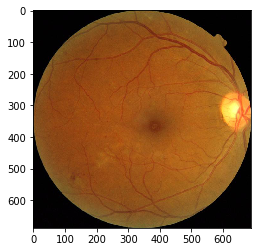

In [5]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('/mnt/lab_data2/avanti/diabetic_retinopathy_messidor/Base11/ds_2_crop_20051019_38557_0100_PP.jpeg')
imgplot = plt.imshow(img)
plt.show()